In [1]:
"""Plot domain mask with develop environment version"""
import os
import PIL.Image
import numpy as np

def create_domain_mask_develop_png():
    domain_mask_png = "/home/HYDROAPP/develop/wh3248/h4/domain_files/domain_mask.png"
    if not os.path.exists(domain_mask_png):
        raise ValueError(f"{domain_mask_png} does not exist")
    pdata = PIL.Image.open(domain_mask_png)
    ndata = np.array(pdata)
    ndata = np.flip(ndata, 0)
    print(ndata.shape)
    ndata = np.where(ndata == 1, 0, 0xFFFF)
    ndata = ndata.astype(np.uint16)
    img = PIL.Image.fromarray(ndata)
    img = img.resize((ndata.shape[0]*10, ndata.shape[1]*10), PIL.Image.NEAREST)
    return img



In [2]:
"""Plot domain mask with main environment version"""
import os
import PIL.Image
import numpy as np
def create_domain_mask_main_png():
    domain_mask_png = "/home/HYDROAPP/main/wh3248/h4/domain_files/domain_mask.png"
    if not os.path.exists(domain_mask_png):
        raise ValueError(f"{domain_mask_png} does not exist")
    pdata = PIL.Image.open(domain_mask_png)
    ndata = np.array(pdata)
    ndata = np.flip(ndata, 0)
    print(ndata.shape)
    ndata = np.where(ndata == 1, 0, 0xFFFF)
    ndata = ndata.astype(np.uint16)
    img = PIL.Image.fromarray(ndata)
    img = img.resize((260, 230), PIL.Image.NEAREST)
    return img


In [21]:
import os
import json

def get_domain_xy_bounds():
    """Return (x_bounds, y_bounds) of domain in X,Y (esri:102004) coordinate space
    The x_bounds [x_low, x_high] and y_bounds = [y_low, y_high].
    For example, x_low is the left most x point in meters (not K meters)
    using the esri:102004 world center point
    """

    domain_state_path = "/home/HYDROAPP/develop/wh3248/h4/domain_state.json"
    if not os.path.exists(domain_state_path):
        raise ValueError(f"{domain_state_path} does not exist.")
    domain_state = {}
    with open(domain_state_path) as stream:
        contents = stream.read()
        domain_state = json.loads(contents)
    grid_bounds = domain_state.get("grid_bounds", None)
    if not grid_bounds:
        raise ValueError("No grid_bounds found of the domain")
    # x,y bbox from CONUS1 shapefile in X,Y (esri:102004) coordinate space
    conus_x_bounds = [-1884563.7545318902, 1457436.245467998]
    conus_y_bounds = [-605655.0023756996, 1282344.9976419993]
    x_bounds = [
        conus_x_bounds[0] + grid_bounds[0] * 1000,
        conus_x_bounds[0] + grid_bounds[2] * 1000,
    ]
    y_bounds = [
        conus_y_bounds[0] + grid_bounds[1] * 1000,
        conus_y_bounds[0] + grid_bounds[3] * 1000,
    ]
    return (x_bounds, y_bounds)


get_domain_xy_bounds()


([-1591563.7545318902, -1568563.7545318902],
 [333344.9976243004, 359344.9976243004])

In [32]:
"""Create heatmap projection png of domain soil moisture forecast"""
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def create_sm_forecast_png(coord_system="epsg:4326"):
    sm_path = "/home/HYDROAPP/develop/wh3248/h4/forecast/1/forecast.2023-03-17_2023-06-14.nc"
    if not os.path.exists(sm_path):
        raise ValueError(f"{sm_path} does not exist.")
    ds = xr.open_dataset(sm_path)
    data_array = ds["soil_moisture"]

    domain_mask_path = "/home/HYDROAPP/develop/wh3248/h4/domain_files/domain_mask.png"
    if not os.path.exists(domain_mask_path):
        raise ValueError(f"{domain_mask_path} does not exist")
    img = PIL.Image.open(domain_mask_path)
    domain_mask = np.array(img)
    cmap = plt.colormaps.get("viridis")
    color_map = (np.array([cmap(v)[0:3] for v in range(0, cmap.N)]) * 255).astype(np.uint8)
    data_array = data_array.isel(time=0)
    data_array = data_array.isel(z=4)
    data_array = data_array.isel(member=0)
    data_np = data_array.to_numpy().astype(int)
    data_df = (pd.DataFrame(data_np).stack().rename_axis(["y", "x"]).reset_index(name="val"))

    cmap_df = pd.DataFrame(color_map, columns=["red", "green", "blue"], dtype=int)
    cmap_df["val"] = np.arange(color_map.shape[0])
    mapped_df = data_df.join(cmap_df, on="val", how="left", rsuffix="val")
    red_numpy = np.reshape(
        mapped_df["red"].to_numpy().astype(np.uint8), data_array.shape
    )
    green_numpy = np.reshape(
        mapped_df["green"].to_numpy().astype(np.uint8), data_array.shape
    )
    blue_numpy = np.reshape(
        mapped_df["blue"].to_numpy().astype(np.uint8), data_array.shape
    )

    red_numpy[domain_mask == 0] = 0xFFFF
    green_numpy[domain_mask == 0] = 0xFFFF
    blue_numpy[domain_mask == 0] = 0xFFFF
    xds = xr.Dataset(
        data_vars=dict(
            R=(["y", "x"], red_numpy),
            G=(["y", "x"], green_numpy),
            B=(["y", "x"], blue_numpy),
        )
    )
    (x_bounds, y_bounds) = get_domain_xy_bounds()
    xcoord = np.linspace(x_bounds[0], x_bounds[1], num=len(xds["x"]))
    ycoord = np.linspace(y_bounds[0], y_bounds[1], num=len(xds["y"]))

    # Assign the esri:102004 coordindates to the xarray dataset
    xds = xds.assign_coords({"x": xcoord, "y": ycoord})
    xds = xds.rio.write_crs("esri:102004")
    xds = xds.rio.write_coordinate_system()

    # project to the lat/lng (epsg:3857) coordindate space
    xds = xds.rio.reproject(coord_system)

    # Convert it to a raster file as a .png
    png_path = "/home/wh3248/tmp/foo.png"
    xds.rio.to_raster(png_path)
    img = PIL.Image.open(png_path)
    img = img.resize((data_np.shape[0]*10, data_np.shape[1]*10), PIL.Image.NEAREST)
    img.save(png_path, transparent=True)
    return png_path
    
create_sm_forecast_png()
        

'/home/wh3248/tmp/foo.png'

(26, 23)


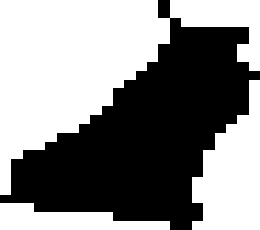

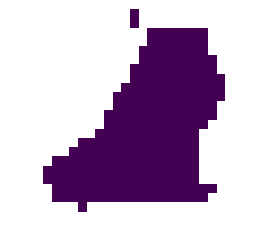

AttributeError: 'Image' object has no attribute 'rotate'

In [39]:
from IPython.display import Image, display
img = create_domain_mask_develop_png()
img.show()
png_path = create_sm_forecast_png()
display(Image(filename=png_path).ro)
png_path = create_sm_forecast_png("epsg:3248")
display(Image(filename=png_path).rotate(90))
